In [1]:
import torch
import torch.nn as nn
from libs.models import encoder3,encoder4
from libs.models import decoder3,decoder4
import numpy as np
from libs.Matrix import MulLayer
from libs.Criterion import LossCriterion
from sklearn.decomposition import PCA


class LossCriterion(nn.Module):
    def __init__(self, style_layers, content_layers, style_weight, content_weight):
        super(LossCriterion, self).__init__()
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.style_weight = style_weight
        self.content_weight = content_weight
        self.styleLosses = [styleLoss()] * len(style_layers)
        self.contentLosses = [nn.MSELoss()] * len(content_layers)

    def forward(self, tF, sF, cF):
        # Content loss
        totalContentLoss = 0
        for i, layer in enumerate(self.content_layers):
            cf_i = cF[layer].detach()
            tf_i = tF[layer]
            loss_i = self.contentLosses[i]
            totalContentLoss += loss_i(tf_i, cf_i)
        totalContentLoss = totalContentLoss * self.content_weight

        # Style loss
        
        totalStyleLoss = 0
        for i, layer in enumerate(self.style_layers):
            sf_i = sF[layer].detach()
            tf_i = tF[layer]
            loss_i = self.styleLosses[i]
            totalStyleLoss += loss_i(tf_i, sf_i)
        totalStyleLoss = totalStyleLoss * self.style_weight

        loss = totalStyleLoss + totalContentLoss
        return loss, totalStyleLoss, totalContentLoss


class styleLoss(nn.Module):
    def forward(self,input,target):
        ib,ic,ih,iw = input.size()
        iF = input.view(ib,ic,-1)
        iMean = torch.mean(iF,dim=2)
        iCov = GramMatrix()(input)

        tb,tc,th,tw = target.size()
        tF = target.view(tb,tc,-1)
        tMean = torch.mean(tF,dim=2)
        tCov = GramMatrix()(target)

        loss = nn.MSELoss(size_average=False)(iMean,tMean) + nn.MSELoss(size_average=False)(iCov,tCov)
        return loss/tb

class GramMatrix(nn.Module):
    def forward(self,input):
        b, c, h, w = input.size()
        f = input.view(b,c,h*w) # bxcx(hxw)
        # torch.bmm(batch1, batch2, out=None)   #
        # batch1: bxmxp, batch2: bxpxn -> bxmxn #
        G = torch.bmm(f,f.transpose(1,2)) # f: bxcx(hxw), f.transpose: bx(hxw)xc -> bxcxc
        return G.div_(c*h*w)

In [2]:
# import torch
# import torch.nn as nn
# import numpy as np
# import matplotlib.pyplot as plt
# from libs.Loader import Dataset
# from libs.models import encoder4, decoder4
# from libs.Criterion import LossCriterion
# from libs.Matrix import MulLayer
# import os
# from typing import List, Tuple
# from tqdm import tqdm
# from sklearn.cluster import KMeans
 
# class LossSensitivity:
#     def __init__(self, vgg: nn.Module, dec: nn.Module, matrix: MulLayer,
#                  style_layers: List[str], content_layers: List[str],
#                  style_weight: float, content_weight: float, device: torch.device):
#         self.vgg = vgg.to(device)
#         self.dec = dec.to(device)
#         self.matrix = matrix.to(device)
#         self.style_layers = style_layers
#         self.content_layers = content_layers
#         self.criterion = LossCriterion(style_layers, content_layers, style_weight, content_weight)
#         self.device = device
 
#     def add_noise(self, matrix: torch.Tensor, sigma: float) -> torch.Tensor:
#         return matrix + torch.randn_like(matrix) * sigma
 
#     @torch.no_grad()
#     def forward(self, contentV: torch.Tensor, styleV: torch.Tensor) -> Tuple[dict, dict]:
#         return self.vgg(styleV), self.vgg(contentV)
 
#     def compute_loss(self, contentV: torch.Tensor, styleV: torch.Tensor, noisy_matrix: torch.Tensor) -> float:
#         sF, cF = self.forward(contentV, styleV)
        
#         transformed_features, _ = self.matrix(cF[self.style_layers[0]], sF[self.style_layers[0]])
#         b, c, h, w = transformed_features.size()
#         compressed_features = self.matrix.compress(transformed_features)
        
#         if noisy_matrix.size(1) != compressed_features.view(b, self.matrix.matrixSize, -1).size(1):
#             print(f"Dimension mismatch: {noisy_matrix.size()} vs {compressed_features.size()}")
#             return float('inf')
        
#         noisy_transfeature = torch.bmm(noisy_matrix, compressed_features.view(b, self.matrix.matrixSize, -1))
#         noisy_transfeature = noisy_transfeature.view(b, self.matrix.matrixSize, h, w)
#         noisy_transfeature = self.matrix.unzip(noisy_transfeature)
        
#         noisy_transfer = self.dec(noisy_transfeature).clamp(0, 1)
#         tF = self.vgg(noisy_transfer)
        
#         total_loss, _, _ = self.criterion(tF, sF, cF)
#         return total_loss.item()
 
#     def compute_matrix_metrics(self, original_matrix: torch.Tensor, noisy_matrix: torch.Tensor) -> Tuple[float, Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]:
#         # Frobenius Norm Difference
#         frobenius_diff = torch.norm(original_matrix - noisy_matrix, p='fro').item()
        
#         # Eigenvalue/Eigenvector Changes
#         orig_eigenvalues, orig_eigenvectors = torch.linalg.eig(original_matrix)
#         noisy_eigenvalues, noisy_eigenvectors = torch.linalg.eig(noisy_matrix)
        
#         return frobenius_diff, (orig_eigenvalues, noisy_eigenvalues), (orig_eigenvectors, noisy_eigenvectors)
 
#     def run_experiment(self, contentV: torch.Tensor, styleV: torch.Tensor,
#                        sigmas: np.ndarray, matrix: torch.Tensor) -> Tuple[List[float], List[float], List[float], List[Tuple[torch.Tensor, torch.Tensor]], List[Tuple[torch.Tensor, torch.Tensor]]]:
#         sigma_values = []
#         loss_values = []
#         frobenius_diffs = []
#         eigenvalue_changes = []
#         eigenvector_changes = []
 
#         for sigma in sigmas:
#             noisy_matrix = self.add_noise(matrix, sigma)
#             loss = self.compute_loss(contentV, styleV, noisy_matrix)
#             if loss == float('inf'):
#                 print(f"Skipping sigma {sigma} due to dimension mismatch.")
#                 continue
            
#             frobenius_diff, eigenvalues, eigenvectors = self.compute_matrix_metrics(matrix, noisy_matrix)
            
#             sigma_values.append(sigma)
#             loss_values.append(loss)
#             frobenius_diffs.append(frobenius_diff)
#             eigenvalue_changes.append(eigenvalues)
#             eigenvector_changes.append(eigenvectors)
 
#         return sigma_values, loss_values, frobenius_diffs, eigenvalue_changes, eigenvector_changes
 
# def process_style_dir(style_dir: str, opt, loss_sensitivity: LossSensitivity,
#                       sigmas: np.ndarray, device: torch.device) -> Tuple[List[List[float]], List[List[float]], List[List[Tuple[torch.Tensor, torch.Tensor]]], List[List[Tuple[torch.Tensor, torch.Tensor]]]]:
#     style_path = os.path.join(opt.matrixPath, style_dir)
#     matrix_files = [f for f in os.listdir(style_path) if f.endswith('.pth')]
#     all_loss_values = []
#     all_frobenius_diffs = []
#     all_eigenvalue_changes = []
#     all_eigenvector_changes = []
 
#     content_dataset = Dataset(opt.contentPath, opt.loadSize, opt.fineSize)
#     style_dataset = Dataset(opt.stylePath, opt.loadSize, opt.fineSize)
#     contentV, _ = content_dataset[0]
#     styleV, _ = style_dataset[0]
#     contentV = contentV.unsqueeze(0).to(device)
#     styleV = styleV.unsqueeze(0).to(device)
 
#     for matrix_file in tqdm(matrix_files, desc=f"Processing {style_dir}"):
#         matrix_path = os.path.join(style_path, matrix_file)
#         saved_matrix = torch.load(matrix_path, map_location=device)
#         _, loss_values, frobenius_diffs, eigenvalue_changes, eigenvector_changes = loss_sensitivity.run_experiment(contentV, styleV, sigmas, saved_matrix)
#         all_loss_values.append(loss_values)
#         all_frobenius_diffs.append(frobenius_diffs)
#         all_eigenvalue_changes.append(eigenvalue_changes)
#         all_eigenvector_changes.append(eigenvector_changes)
 
#     return all_loss_values, all_frobenius_diffs, all_eigenvalue_changes, all_eigenvector_changes
 
# def plot_style_results(style_dir: str, sigmas: np.ndarray, avg_loss_values: np.ndarray, avg_frobenius_diffs: np.ndarray):
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
#     ax1.plot(sigmas[:len(avg_loss_values)], avg_loss_values, '-o')
#     ax1.set_xlabel('Sigma (Noise Level)')
#     ax1.set_ylabel('Average Total Loss')
#     ax1.set_title(f'Average Noise Sensitivity for Style: {style_dir}')
#     ax1.grid(True)
    
#     ax2.plot(sigmas[:len(avg_frobenius_diffs)], avg_frobenius_diffs, '-o')
#     ax2.set_xlabel('Sigma (Noise Level)')
#     ax2.set_ylabel('Average Frobenius Norm Difference')
#     ax2.set_title(f'Average Matrix Change for Style: {style_dir}')
#     ax2.grid(True)
    
#     plt.tight_layout()
#     plt.savefig(f'noise_sensitivity_{style_dir}.png')
#     plt.show()
 
# def analyze_eigenvalue_changes(style_dir: str, sigmas: np.ndarray, eigenvalue_changes: List[Tuple[torch.Tensor, torch.Tensor]]):
#     avg_eigenvalue_diffs = []
#     for orig, noisy in eigenvalue_changes:
#         avg_diff = torch.mean(torch.abs(orig - noisy)).item()
#         avg_eigenvalue_diffs.append(avg_diff)
    
#     plt.figure(figsize=(10, 6))
#     plt.plot(sigmas, avg_eigenvalue_diffs, '-o')
#     plt.xlabel('Sigma (Noise Level)')
#     plt.ylabel('Average Eigenvalue Difference')
#     plt.title(f'Eigenvalue Sensitivity for Style: {style_dir}')
#     plt.grid(True)
#     plt.savefig(f'eigenvalue_sensitivity_{style_dir}.png')
#     plt.show()
    
# def plot_average_frobenius_norm_trend(sigmas: np.ndarray, all_styles_frobenius_diffs: List[np.ndarray]):
#     """
#     Plot the average Frobenius norm trend across all styles.
    
#     :param sigmas: Array of noise levels
#     :param all_styles_frobenius_diffs: List of Frobenius norm differences for each style
#     """
#     avg_frobenius_diffs = np.mean(all_styles_frobenius_diffs, axis=0)
#     std_frobenius_diffs = np.std(all_styles_frobenius_diffs, axis=0)
 
#     plt.figure(figsize=(12, 6))
#     plt.plot(sigmas, avg_frobenius_diffs, '-o', label='Average')
#     plt.fill_between(sigmas,
#                      avg_frobenius_diffs - std_frobenius_diffs,
#                      avg_frobenius_diffs + std_frobenius_diffs,
#                      alpha=0.2, label='Standard Deviation')
    
#     plt.xlabel('Sigma (Noise Level)')
#     plt.ylabel('Average Frobenius Norm Difference')
#     plt.title('Average Frobenius Norm Trend Across All Styles')
#     plt.legend()
#     plt.grid(True)
#     plt.savefig('average_frobenius_norm_trend.png')
#     plt.show()   
 
# def identify_sensitive_components(style_dir: str, sigmas: np.ndarray, eigenvalue_changes: List[Tuple[torch.Tensor, torch.Tensor]]):
#     num_eigenvalues = eigenvalue_changes[0][0].shape[0]
#     eigenvalue_sensitivities = [[] for _ in range(num_eigenvalues)]
    
#     for orig, noisy in eigenvalue_changes:
#         diffs = torch.abs(orig - noisy)
#         for i in range(num_eigenvalues):
#             eigenvalue_sensitivities[i].append(diffs[i].item())
    
#     plt.figure(figsize=(12, 8))
#     for i in range(num_eigenvalues):
#         plt.plot(sigmas, eigenvalue_sensitivities[i], label=f'Eigenvalue {i+1}')
#     plt.xlabel('Sigma (Noise Level)')
#     plt.ylabel('Eigenvalue Difference')
#     plt.title(f'Individual Eigenvalue Sensitivities for Style: {style_dir}')
#     plt.legend()
#     plt.grid(True)
#     plt.savefig(f'individual_eigenvalue_sensitivities_{style_dir}.png')
#     plt.show()
 
# class Options:
    
#     def __init__(self):
#         self.contentPath = "data/content/"
#         self.stylePath = "data/style/"
#         self.loadSize = 256
#         self.fineSize = 256
#         self.matrixPath = "Matrices/"
        
# def load_models(device: torch.device) -> Tuple[nn.Module, nn.Module, MulLayer]:
#     vgg = encoder4()
#     dec = decoder4()
#     matrix = MulLayer('r41')
#     vgg.load_state_dict(torch.load('models/vgg_r41.pth', map_location=device))
#     dec.load_state_dict(torch.load('models/dec_r41.pth', map_location=device))
#     return vgg, dec, matrix        
 
# def plot_average_frobenius_norm_trend(sigmas: np.ndarray, all_styles_frobenius_diffs: List[np.ndarray]):
#     """
#     Plot the average Frobenius norm trend across all styles with standard deviation.
    
#     :param sigmas: Array of noise levels
#     :param all_styles_frobenius_diffs: List of Frobenius norm differences for each style
#     """
#     avg_frobenius_diffs = np.mean(all_styles_frobenius_diffs, axis=0)
#     std_frobenius_diffs = np.std(all_styles_frobenius_diffs, axis=0)
 
#     plt.figure(figsize=(12, 6))
#     plt.plot(sigmas, avg_frobenius_diffs, '-', color='blue', label='Average')
#     plt.fill_between(sigmas,
#                      avg_frobenius_diffs - std_frobenius_diffs,
#                      avg_frobenius_diffs + std_frobenius_diffs,
#                      alpha=0.3, color='lightblue', label='±1 Standard Deviation')
 
#     # Plot ±1 standard deviation lines
#     plt.plot(sigmas, avg_frobenius_diffs - std_frobenius_diffs, '--', color='red', alpha=0.5, label='-1 Std Dev')
#     plt.plot(sigmas, avg_frobenius_diffs + std_frobenius_diffs, '--', color='red', alpha=0.5, label='+1 Std Dev')
    
#     plt.xlabel('Sigma (Noise Level)')
#     plt.ylabel('Average Frobenius Norm Difference')
#     plt.title('Average Frobenius Norm Trend Across All Styles')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.savefig('average_frobenius_norm_trend.png', dpi=300)
#     plt.show()
 
#     # Print some statistics
#     print(f"Maximum average Frobenius norm difference: {np.max(avg_frobenius_diffs):.4f}")
#     print(f"Maximum standard deviation: {np.max(std_frobenius_diffs):.4f}")
#     print(f"Sigma at maximum average difference: {sigmas[np.argmax(avg_frobenius_diffs)]:.4f}")
 
# def main():
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     vgg, dec, matrix = load_models(device)
    
#     style_layers = ['r41']
#     content_layers = ['r41']
#     style_weight = 1e5
#     content_weight = 1.0
 
#     opt = Options()
#     loss_sensitivity = LossSensitivity(vgg, dec, matrix, style_layers, content_layers,
#                                        style_weight, content_weight, device)
 
#     sigmas = np.linspace(0, 0.2, 100)
#     style_dirs = [d for d in os.listdir(opt.matrixPath) if os.path.isdir(os.path.join(opt.matrixPath, d))]
    
#     all_styles_frobenius_diffs = []
 
#     for style_dir in style_dirs:
#         all_loss_values, all_frobenius_diffs, all_eigenvalue_changes, all_eigenvector_changes = process_style_dir(style_dir, opt, loss_sensitivity, sigmas, device)
        
#         if all_loss_values:
#             avg_loss_values = np.mean(all_loss_values, axis=0)
#             avg_frobenius_diffs = np.mean(all_frobenius_diffs, axis=0)
#             all_styles_frobenius_diffs.append(avg_frobenius_diffs)
#             plot_style_results(style_dir, sigmas, avg_loss_values, avg_frobenius_diffs)
            
#             # ... (rest of the code in the loop remains the same)
 
#     # Plot average Frobenius norm trend across all styles
#     if all_styles_frobenius_diffs:
#         plot_average_frobenius_norm_trend(sigmas, all_styles_frobenius_diffs)
#     else:
#         print("Warning: No Frobenius norm data available for analysis across styles.")
 
# if __name__ == "__main__":
#     main()

/tmp/ipykernel_119597/3211233549.py:239: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg.load_state_dict(torch.load('models/vgg_r41.pth', map_location=device))
/tmp/ipyker

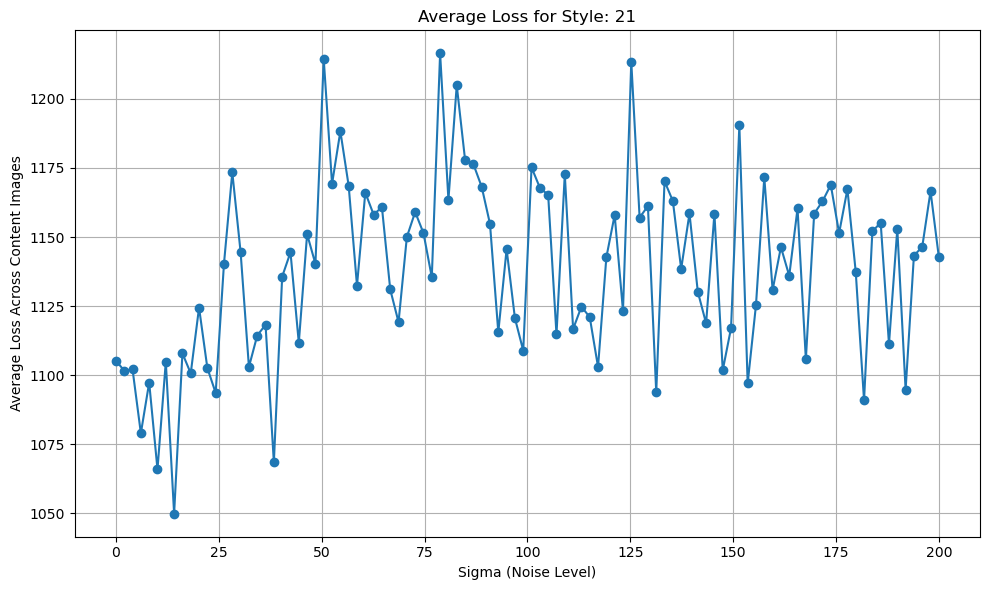

Processing 05: 100%|██████████| 16/16 [07:52<00:00, 29.52s/it]


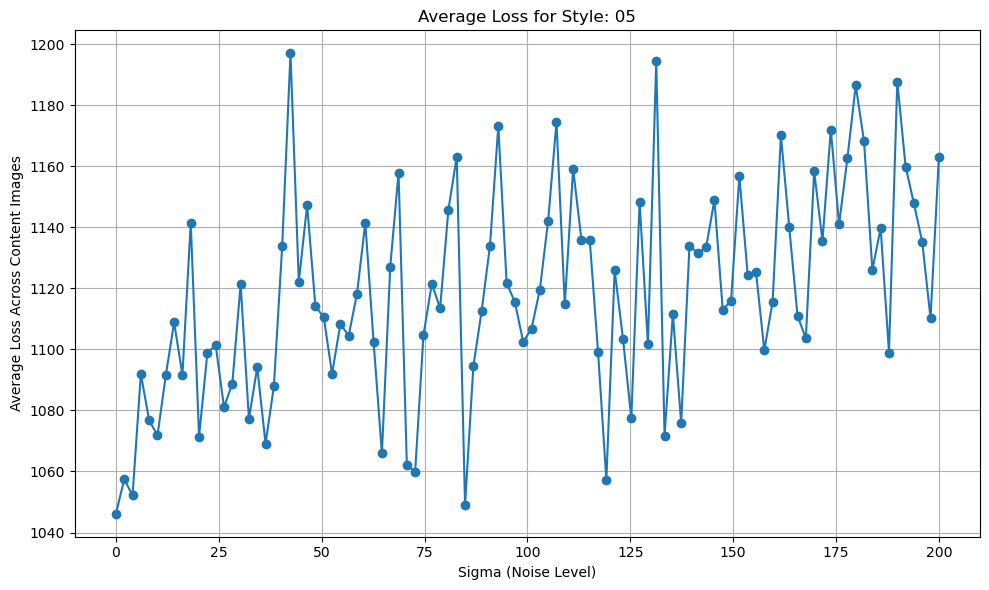

Processing 11: 100%|██████████| 16/16 [07:51<00:00, 29.47s/it]


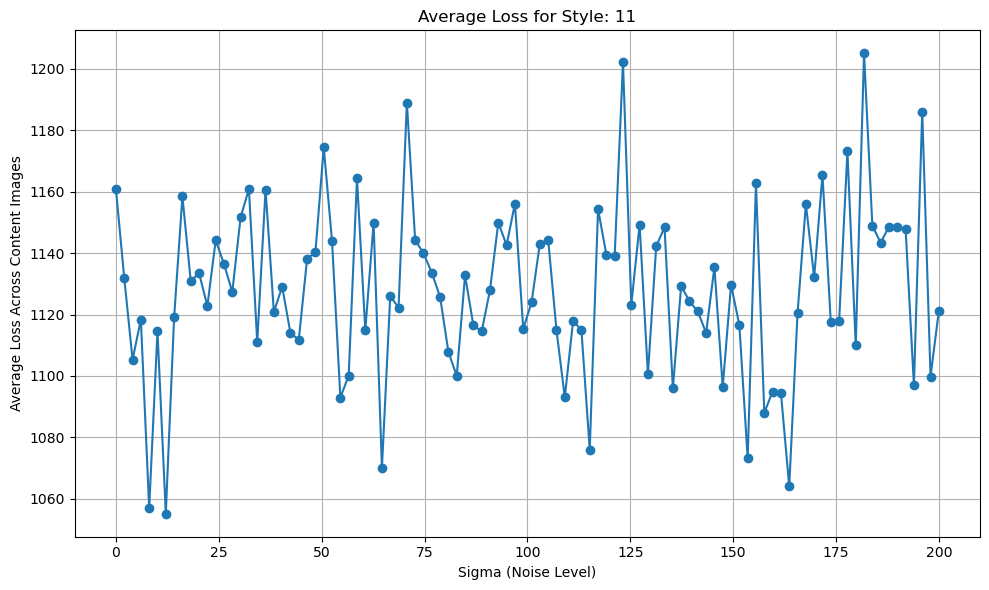

Processing 17:  81%|████████▏ | 13/16 [06:33<01:30, 30.26s/it]


KeyboardInterrupt: 

In [6]:
import torch
import torch.nn as nn
from libs.models import encoder3,encoder4
from libs.models import decoder3,decoder4
import numpy as np
from libs.Matrix import MulLayer
from libs.Criterion import LossCriterion
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from libs.Loader import Dataset
import os
from typing import List, Tuple
from tqdm import tqdm
import torch.nn.functional as F

class LossCriterion(nn.Module):
    def __init__(self, style_layers, content_layers, style_weight, content_weight):
        super(LossCriterion, self).__init__()
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.style_weight = style_weight
        self.content_weight = content_weight
        self.styleLosses = [styleLoss()] * len(style_layers)
        self.contentLosses = [nn.MSELoss()] * len(content_layers)

    def forward(self, tF, sF, cF):
        # Content loss
        totalContentLoss = 0
        for i, layer in enumerate(self.content_layers):
            cf_i = cF[layer].detach()
            tf_i = tF[layer]
            loss_i = self.contentLosses[i]
            totalContentLoss += loss_i(tf_i, cf_i)
        totalContentLoss = totalContentLoss * self.content_weight

        # Style loss
        
        totalStyleLoss = 0
        for i, layer in enumerate(self.style_layers):
            sf_i = sF[layer].detach()
            tf_i = tF[layer]
            loss_i = self.styleLosses[i]
            totalStyleLoss += loss_i(tf_i, sf_i)
        totalStyleLoss = totalStyleLoss * self.style_weight

        loss = totalStyleLoss + totalContentLoss
        return loss, totalStyleLoss, totalContentLoss


class styleLoss(nn.Module):
    def forward(self,input,target):
        ib,ic,ih,iw = input.size()
        iF = input.view(ib,ic,-1)
        iMean = torch.mean(iF,dim=2)
        iCov = GramMatrix()(input)

        tb,tc,th,tw = target.size()
        tF = target.view(tb,tc,-1)
        tMean = torch.mean(tF,dim=2)
        tCov = GramMatrix()(target)

        loss = nn.MSELoss(size_average=False)(iMean,tMean) + nn.MSELoss(size_average=False)(iCov,tCov)
        return loss/tb

class GramMatrix(nn.Module):
    def forward(self,input):
        b, c, h, w = input.size()
        f = input.view(b,c,h*w) # bxcx(hxw)
        # torch.bmm(batch1, batch2, out=None)   #
        # batch1: bxmxp, batch2: bxpxn -> bxmxn #
        G = torch.bmm(f,f.transpose(1,2)) # f: bxcx(hxw), f.transpose: bx(hxw)xc -> bxcxc
        return G.div_(c*h*w)



class LossSensitivity:
    def __init__(self, vgg: nn.Module, dec: nn.Module, matrix: MulLayer,
                 style_layers: List[str], content_layers: List[str],
                 style_weight: float, content_weight: float, device: torch.device):
        self.vgg = vgg.to(device)
        self.dec = dec.to(device)
        self.matrix = matrix.to(device)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.criterion = LossCriterion(style_layers, content_layers, style_weight, content_weight)
        self.device = device

    def add_noise(self, matrix: torch.Tensor, sigma: float) -> torch.Tensor:
        """Adds random Gaussian noise to a matrix."""
        return matrix + torch.randn_like(matrix) * sigma

    @torch.no_grad()
    def forward(self, contentV: torch.Tensor, styleV: torch.Tensor) -> Tuple[dict, dict]:
        return self.vgg(styleV), self.vgg(contentV)

    def compute_loss(self, contentV: torch.Tensor, styleV: torch.Tensor, noisy_matrix: torch.Tensor) -> float:
        sF, cF = self.forward(contentV, styleV)

        transformed_features, _ = self.matrix(cF[self.style_layers[0]], sF[self.style_layers[0]])
        b, c, h, w = transformed_features.size()
        compressed_features = self.matrix.compress(transformed_features)

        if noisy_matrix.size(1) != compressed_features.view(b, self.matrix.matrixSize, -1).size(1):
            print(f"Dimension mismatch: {noisy_matrix.size()} vs {compressed_features.size()}")
            return float('inf')

        noisy_transfeature = torch.bmm(noisy_matrix, compressed_features.view(b, self.matrix.matrixSize, -1))
        noisy_transfeature = noisy_transfeature.view(b, self.matrix.matrixSize, h, w)
        noisy_transfeature = self.matrix.unzip(noisy_transfeature)

        noisy_transfer = self.dec(noisy_transfeature).clamp(0, 1)
        tF = self.vgg(noisy_transfer)

        total_loss, _, _ = self.criterion(tF, sF, cF)
        return total_loss.item()

    # def generate_stylized_image(self, contentV: torch.Tensor, styleV: torch.Tensor, noisy_matrix: torch.Tensor) -> torch.Tensor:
    #     """Generates the stylized image using the given noisy transformation matrix."""
    #     sF, cF = self.forward(contentV, styleV)

    #     transformed_features, _ = self.matrix(cF[self.style_layers[0]], sF[self.style_layers[0]])
    #     b, c, h, w = transformed_features.size()
    #     compressed_features = self.matrix.compress(transformed_features)

    #     noisy_transfeature = torch.bmm(noisy_matrix, compressed_features.view(b, self.matrix.matrixSize, -1))
    #     noisy_transfeature = noisy_transfeature.view(b, self.matrix.matrixSize, h, w)
    #     noisy_transfeature = self.matrix.unzip(noisy_transfeature)

    #     noisy_transfer = self.dec(noisy_transfeature).clamp(0, 1)
    #     return noisy_transfer

    def run_experiment(self, contentV: torch.Tensor, styleV: torch.Tensor,
                       sigmas: np.ndarray, matrix: torch.Tensor) -> List[float]:
        """Runs the experiment for different noise levels and computes loss for each."""
        loss_values = []

        for sigma in sigmas:
            noisy_matrix = self.add_noise(matrix, sigma)

            loss = self.compute_loss(contentV, styleV, noisy_matrix)
            if loss == float('inf'):
                print(f"Skipping sigma {sigma} due to dimension mismatch.")
                continue

            loss_values.append(loss)  # Store only the loss related to random noise

        return loss_values


def process_style_dir(style_dir: str, opt, loss_sensitivity: LossSensitivity,
                      sigmas: np.ndarray, device: torch.device) -> np.ndarray:
    style_path = os.path.join(opt.matrixPath, style_dir)
    matrix_files = [f for f in os.listdir(style_path) if f.endswith('.pth')]

    total_loss_values = np.zeros(len(sigmas))
    num_matrices = 0

    content_dataset = Dataset(opt.contentPath, opt.loadSize, opt.fineSize)
    style_dataset = Dataset(opt.stylePath, opt.loadSize, opt.fineSize)

    # Loop over all matrices saved for this style
    for matrix_file in tqdm(matrix_files, desc=f"Processing {style_dir}"):
        matrix_path = os.path.join(style_path, matrix_file)
        saved_matrix = torch.load(matrix_path, map_location=device)

        num_content_images = 0
        loss_values_accumulated = np.zeros(len(sigmas))

        # Loop over all content images
        for contentV, _ in content_dataset:
            contentV = contentV.unsqueeze(0).to(device)
            styleV = style_dataset[0][0].unsqueeze(0).to(device)

            # Run experiment for this content image
            loss_values = loss_sensitivity.run_experiment(contentV, styleV, sigmas, saved_matrix)

            # Accumulate losses for each sigma
            loss_values_accumulated += np.array(loss_values)
            num_content_images += 1

        # Average loss values for each content image and add to total losses
        total_loss_values += loss_values_accumulated / num_content_images
        num_matrices += 1

    # Average the accumulated results over the number of style matrices
    avg_loss_values = total_loss_values / num_matrices

    return avg_loss_values



def plot_style_results(style_dir: str, sigmas: np.ndarray, avg_loss_values: np.ndarray):
    plt.figure(figsize=(10, 6))

    plt.plot(sigmas, avg_loss_values, '-o')
    plt.xlabel('Sigma (Noise Level)')
    plt.ylabel('Average Loss')
    plt.title(f'Loss Sensitivity for Style: {style_dir}')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'noise_sensitivity_{style_dir}.png')
    plt.show()


def plot_intermediate_images(intermediate_images: List[Tuple[float, torch.Tensor]], style_dir: str):
    """Plot intermediate stylized images for the given sigma levels."""
    plt.figure(figsize=(15, 5))
    num_images = len(intermediate_images)

    for idx, (sigma, image_tensor) in enumerate(intermediate_images):
        plt.subplot(1, num_images, idx + 1)
        image = image_tensor.squeeze().permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.title(f'Sigma = {sigma:.2f}')
        plt.axis('off')

    plt.suptitle(f'Stylized Images for Style: {style_dir}')
    plt.tight_layout()
    plt.savefig(f'stylized_images_{style_dir}.png')
    plt.show()


def plot_style_loss_trend_for_noise_level(style_dir: str, sigmas: np.ndarray, avg_loss_values: np.ndarray):
    plt.figure(figsize=(10, 6))
    plt.plot(sigmas, avg_loss_values, '-o')
    plt.xlabel('Sigma (Noise Level)')
    plt.ylabel('Average Loss Across Content Images')
    plt.title(f'Average Loss for Style: {style_dir}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def load_models(device: torch.device) -> Tuple[nn.Module, nn.Module, MulLayer]:
    vgg = encoder4()
    dec = decoder4()
    matrix = MulLayer('r41')
    vgg.load_state_dict(torch.load('models/vgg_r41.pth', map_location=device))
    dec.load_state_dict(torch.load('models/dec_r41.pth', map_location=device))
    return vgg, dec, matrix

class Options:
    def __init__(self):
        self.contentPath = "data/content/"
        self.stylePath = "data/style/"
        self.loadSize = 256
        self.fineSize = 256
        self.matrixPath = "Matrices/"

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load models
    vgg, dec, matrix = load_models(device)

    # Define options and parameters
    opt = Options()
    sigmas = np.linspace(0, 200, 100)  # Noise levels to test

    # Initialize the loss sensitivity object with valid layer identifiers
    loss_sensitivity = LossSensitivity(vgg, dec, matrix, style_layers=['r41'], content_layers=['r41'],
                                       style_weight=1.0, content_weight=1.0, device=device)

    # Loop over style directories
    style_dirs = os.listdir(opt.matrixPath)

    for style_dir in style_dirs:
        # Process each style directory to get average loss values for each sigma
        avg_loss_values = process_style_dir(style_dir, opt, loss_sensitivity, sigmas, device)

        # Plot the trend of average loss across content images for this style
        plot_style_loss_trend_for_noise_level(style_dir, sigmas, avg_loss_values)

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from libs.Loader import Dataset
from libs.models import encoder4, decoder4
from libs.Criterion import LossCriterion
from libs.Matrix import MulLayer
import os
from typing import List, Tuple
from tqdm import tqdm
from sklearn.cluster import KMeans
 
class LossSensitivity:
    def __init__(self, vgg: nn.Module, dec: nn.Module, matrix: MulLayer,
                 style_layers: List[str], content_layers: List[str],
                 style_weight: float, content_weight: float, device: torch.device):
        self.vgg = vgg.to(device)
        self.dec = dec.to(device)
        self.matrix = matrix.to(device)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.criterion = LossCriterion(style_layers, content_layers, style_weight, content_weight)
        self.device = device
 
    def add_noise(self, matrix: torch.Tensor, sigma: float) -> torch.Tensor:
        return matrix + torch.randn_like(matrix) * sigma
 
    @torch.no_grad()
    def forward(self, contentV: torch.Tensor, styleV: torch.Tensor) -> Tuple[dict, dict]:
        return self.vgg(styleV), self.vgg(contentV)
 
    def compute_loss(self, contentV: torch.Tensor, styleV: torch.Tensor, noisy_matrix: torch.Tensor) -> float:
        sF, cF = self.forward(contentV, styleV)
        
        transformed_features, _ = self.matrix(cF[self.style_layers[0]], sF[self.style_layers[0]])
        b, c, h, w = transformed_features.size()
        compressed_features = self.matrix.compress(transformed_features)
        
        if noisy_matrix.size(1) != compressed_features.view(b, self.matrix.matrixSize, -1).size(1):
            print(f"Dimension mismatch: {noisy_matrix.size()} vs {compressed_features.size()}")
            return float('inf')
        
        noisy_transfeature = torch.bmm(noisy_matrix, compressed_features.view(b, self.matrix.matrixSize, -1))
        noisy_transfeature = noisy_transfeature.view(b, self.matrix.matrixSize, h, w)
        noisy_transfeature = self.matrix.unzip(noisy_transfeature)
        
        noisy_transfer = self.dec(noisy_transfeature).clamp(0, 1)
        tF = self.vgg(noisy_transfer)
        
        total_loss, _, _ = self.criterion(tF, sF, cF)
        return total_loss.item()
 
    def compute_matrix_metrics(self, original_matrix: torch.Tensor, noisy_matrix: torch.Tensor) -> Tuple[float, Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]:
        # Frobenius Norm Difference
        frobenius_diff = torch.norm(original_matrix - noisy_matrix, p='fro').item()
        
        # Eigenvalue/Eigenvector Changes
        orig_eigenvalues, orig_eigenvectors = torch.linalg.eig(original_matrix)
        noisy_eigenvalues, noisy_eigenvectors = torch.linalg.eig(noisy_matrix)
        
        return frobenius_diff, (orig_eigenvalues, noisy_eigenvalues), (orig_eigenvectors, noisy_eigenvectors)
 
    def run_experiment(self, contentV: torch.Tensor, styleV: torch.Tensor,
                       sigmas: np.ndarray, matrix: torch.Tensor) -> Tuple[List[float], List[float], List[float], List[Tuple[torch.Tensor, torch.Tensor]], List[Tuple[torch.Tensor, torch.Tensor]]]:
        sigma_values = []
        loss_values = []
        frobenius_diffs = []
        eigenvalue_changes = []
        eigenvector_changes = []
 
        for sigma in sigmas:
            noisy_matrix = self.add_noise(matrix, sigma)
            loss = self.compute_loss(contentV, styleV, noisy_matrix)
            if loss == float('inf'):
                print(f"Skipping sigma {sigma} due to dimension mismatch.")
                continue
            
            frobenius_diff, eigenvalues, eigenvectors = self.compute_matrix_metrics(matrix, noisy_matrix)
            
            sigma_values.append(sigma)
            loss_values.append(loss)
            frobenius_diffs.append(frobenius_diff)
            eigenvalue_changes.append(eigenvalues)
            eigenvector_changes.append(eigenvectors)
 
        return sigma_values, loss_values, frobenius_diffs, eigenvalue_changes, eigenvector_changes
 

def process_style_dir(style_dir: str, opt, loss_sensitivity: LossSensitivity,
                      sigmas: np.ndarray, device: torch.device) -> Tuple[List[List[float]], List[List[float]], List[List[Tuple[torch.Tensor, torch.Tensor]]], List[List[Tuple[torch.Tensor, torch.Tensor]]]]:
    style_path = os.path.join(opt.matrixPath, style_dir)
    matrix_files = [f for f in os.listdir(style_path) if f.endswith('.pth')]
    all_loss_values = []
    all_frobenius_diffs = []
    all_eigenvalue_changes = []
    all_eigenvector_changes = []

    content_dataset = Dataset(opt.contentPath, opt.loadSize, opt.fineSize)
    style_dataset = Dataset(opt.stylePath, opt.loadSize, opt.fineSize)
    contentV, _ = content_dataset[0]
    styleV, _ = style_dataset[0]
    contentV = contentV.unsqueeze(0).to(device)
    styleV = styleV.unsqueeze(0).to(device)

    for matrix_file in tqdm(matrix_files, desc=f"Processing {style_dir}"):
        matrix_path = os.path.join(style_path, matrix_file)
        saved_matrix = torch.load(matrix_path, map_location=device)
        _, loss_values, frobenius_diffs, eigenvalue_changes, eigenvector_changes = loss_sensitivity.run_experiment(contentV, styleV, sigmas, saved_matrix)
        all_loss_values.append(loss_values)
        all_frobenius_diffs.append(frobenius_diffs)
        all_eigenvalue_changes.append(eigenvalue_changes)
        all_eigenvector_changes.append(eigenvector_changes)

    return all_loss_values, all_frobenius_diffs, all_eigenvalue_changes, all_eigenvector_changes

def plot_style_results(style_dir: str, sigmas: np.ndarray, avg_loss_values: np.ndarray, avg_frobenius_diffs: np.ndarray):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    ax1.plot(sigmas[:len(avg_loss_values)], avg_loss_values, '-o')
    ax1.set_xlabel('Sigma (Noise Level)')
    ax1.set_ylabel('Average Total Loss')
    ax1.set_title(f'Average Noise Sensitivity for Style: {style_dir}')
    ax1.grid(True)
    
    ax2.plot(sigmas[:len(avg_frobenius_diffs)], avg_frobenius_diffs, '-o')
    ax2.set_xlabel('Sigma (Noise Level)')
    ax2.set_ylabel('Average Frobenius Norm Difference')
    ax2.set_title(f'Average Matrix Change for Style: {style_dir}')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'noise_sensitivity_{style_dir}.png')
    plt.close()

def analyze_eigenvalue_changes(style_dir: str, sigmas: np.ndarray, eigenvalue_changes: List[Tuple[torch.Tensor, torch.Tensor]]):
    avg_eigenvalue_diffs = []
    for orig, noisy in eigenvalue_changes:
        avg_diff = torch.mean(torch.abs(orig - noisy)).item()
        avg_eigenvalue_diffs.append(avg_diff)
    
    plt.figure(figsize=(10, 6))
    plt.plot(sigmas, avg_eigenvalue_diffs, '-o')
    plt.xlabel('Sigma (Noise Level)')
    plt.ylabel('Average Eigenvalue Difference')
    plt.title(f'Eigenvalue Sensitivity for Style: {style_dir}')
    plt.grid(True)
    plt.savefig(f'eigenvalue_sensitivity_{style_dir}.png')
    plt.close()

def plot_average_frobenius_norm_trend(sigmas: np.ndarray, all_styles_frobenius_diffs: List[np.ndarray]):
    avg_frobenius_diffs = np.mean(all_styles_frobenius_diffs, axis=0)
    std_frobenius_diffs = np.std(all_styles_frobenius_diffs, axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(sigmas, avg_frobenius_diffs, '-', color='blue', label='Average')
    plt.fill_between(sigmas,
                     avg_frobenius_diffs - std_frobenius_diffs,
                     avg_frobenius_diffs + std_frobenius_diffs,
                     alpha=0.3, color='lightblue', label='±1 Standard Deviation')

    plt.plot(sigmas, avg_frobenius_diffs - std_frobenius_diffs, '--', color='red', alpha=0.5, label='-1 Std Dev')
    plt.plot(sigmas, avg_frobenius_diffs + std_frobenius_diffs, '--', color='red', alpha=0.5, label='+1 Std Dev')
    
    plt.xlabel('Sigma (Noise Level)')
    plt.ylabel('Average Frobenius Norm Difference')
    plt.title('Average Frobenius Norm Trend Across All Styles')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('average_frobenius_norm_trend.png', dpi=300)
    plt.close()

    print(f"Maximum average Frobenius norm difference: {np.max(avg_frobenius_diffs):.4f}")
    print(f"Maximum standard deviation: {np.max(std_frobenius_diffs):.4f}")
    print(f"Sigma at maximum average difference: {sigmas[np.argmax(avg_frobenius_diffs)]:.4f}")

def identify_sensitive_components(style_dir: str, sigmas: np.ndarray, eigenvalue_changes: List[Tuple[torch.Tensor, torch.Tensor]]):
    num_eigenvalues = eigenvalue_changes[0][0].shape[0]
    eigenvalue_sensitivities = [[] for _ in range(num_eigenvalues)]
    
    for orig, noisy in eigenvalue_changes:
        diffs = torch.abs(orig - noisy)
        for i in range(num_eigenvalues):
            eigenvalue_sensitivities[i].append(diffs[i].item())
    
    plt.figure(figsize=(12, 8))
    for i in range(num_eigenvalues):
        plt.plot(sigmas, eigenvalue_sensitivities[i], label=f'Eigenvalue {i+1}')
    plt.xlabel('Sigma (Noise Level)')
    plt.ylabel('Eigenvalue Difference')
    plt.title(f'Individual Eigenvalue Sensitivities for Style: {style_dir}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'individual_eigenvalue_sensitivities_{style_dir}.png')
    plt.close()

class Options:
    def __init__(self):
        self.contentPath = "data/content/"
        self.stylePath = "data/style/"
        self.loadSize = 256
        self.fineSize = 256
        self.matrixPath = "Matrices/"

def load_models(device: torch.device) -> Tuple[nn.Module, nn.Module, MulLayer]:
    vgg = encoder4()
    dec = decoder4()
    matrix = MulLayer('r41')
    vgg.load_state_dict(torch.load('models/vgg_r41.pth', map_location=device))
    dec.load_state_dict(torch.load('models/dec_r41.pth', map_location=device))
    return vgg, dec, matrix

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vgg, dec, matrix = load_models(device)
    
    style_layers = ['r41']
    content_layers = ['r41']
    style_weight = 1e5
    content_weight = 1.0

    opt = Options()
    loss_sensitivity = LossSensitivity(vgg, dec, matrix, style_layers, content_layers,
                                       style_weight, content_weight, device)

    sigmas = np.linspace(0, 0.2, 100)
    style_dirs = [d for d in os.listdir(opt.matrixPath) if os.path.isdir(os.path.join(opt.matrixPath, d))]
    
    all_styles_frobenius_diffs = []

    for style_dir in style_dirs:
        try:
            all_loss_values, all_frobenius_diffs, all_eigenvalue_changes, all_eigenvector_changes = process_style_dir(style_dir, opt, loss_sensitivity, sigmas, device)
            
            if all_loss_values:
                avg_loss_values = np.mean(all_loss_values, axis=0)
                avg_frobenius_diffs = np.mean(all_frobenius_diffs, axis=0)
                all_styles_frobenius_diffs.append(avg_frobenius_diffs)
                plot_style_results(style_dir, sigmas, avg_loss_values, avg_frobenius_diffs)
                analyze_eigenvalue_changes(style_dir, sigmas, all_eigenvalue_changes[0])  # Analyze first set of eigenvalue changes
                identify_sensitive_components(style_dir, sigmas, all_eigenvalue_changes[0])
            else:
                print(f"Warning: No data available for style directory {style_dir}")
        except Exception as e:
            print(f"Error processing style directory {style_dir}: {str(e)}")

    if all_styles_frobenius_diffs:
        plot_average_frobenius_norm_trend(sigmas, all_styles_frobenius_diffs)
    else:
        print("Warning: No Frobenius norm data available for analysis across styles.")

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import List, Tuple
from tqdm import tqdm
from sklearn.cluster import KMeans

class LossSensitivity:
    def __init__(self, vgg: nn.Module, dec: nn.Module, matrix: MulLayer, 
                 style_layers: List[str], content_layers: List[str], 
                 style_weight: float, content_weight: float, device: torch.device):
        self.vgg = vgg.to(device)
        self.dec = dec.to(device)
        self.matrix = matrix.to(device)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.criterion = LossCriterion(style_layers, content_layers, style_weight, content_weight)
        self.device = device

    @torch.no_grad()
    def forward(self, contentV: torch.Tensor, styleV: torch.Tensor) -> Tuple[dict, dict]:
        return self.vgg(styleV), self.vgg(contentV)

    def compute_loss(self, contentV: torch.Tensor, styleV: torch.Tensor, transmatrix: torch.Tensor) -> float:
        sF, cF = self.forward(contentV, styleV)
        
        transformed_features, _ = self.matrix(cF[self.style_layers[0]], sF[self.style_layers[0]])
        b, c, h, w = transformed_features.size()
        compressed_features = self.matrix.compress(transformed_features)
        
        transfeature = torch.bmm(transmatrix, compressed_features.view(b, self.matrix.matrixSize, -1))
        transfeature = transfeature.view(b, self.matrix.matrixSize, h, w)
        transfeature = self.matrix.unzip(transfeature)
        
        transfer = self.dec(transfeature).clamp(0, 1)
        tF = self.vgg(transfer)
        
        total_loss, _, _ = self.criterion(tF, sF, cF)
        return total_loss.item()

    def run_dimension_dropping_experiment(self, contentV: torch.Tensor, styleV: torch.Tensor) -> Tuple[List[float], List[float]]:
        sF, cF = self.forward(contentV, styleV)
        
        content_features = cF[self.style_layers[0]]
        style_features = sF[self.style_layers[0]]
        
        b, c, h, w = content_features.size()
        
        content_loss_impacts = []
        style_loss_impacts = []
        
        # Calculate baseline loss
        _, baseline_matrix = self.matrix(content_features, style_features)
        baseline_loss = self.compute_loss(contentV, styleV, baseline_matrix)
        
        # Analyze content dimensions
        for dim in tqdm(range(c), desc="Analyzing content dimensions"):
            dropped_content = content_features.clone()
            dropped_content[:, dim, :, :] = 0
            
            _, transmatrix = self.matrix(dropped_content, style_features)
            loss = self.compute_loss(contentV, styleV, transmatrix)
            content_loss_impacts.append(loss - baseline_loss)
        
        # Analyze style dimensions
        for dim in tqdm(range(c), desc="Analyzing style dimensions"):
            dropped_style = style_features.clone()
            dropped_style[:, dim, :, :] = 0
            
            _, transmatrix = self.matrix(content_features, dropped_style)
            loss = self.compute_loss(contentV, styleV, transmatrix)
            style_loss_impacts.append(loss - baseline_loss)
        
        return content_loss_impacts, style_loss_impacts 

def plot_dimension_dropping_results(content_loss_impacts: List[float], style_loss_impacts: List[float], style_name: str):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(content_loss_impacts)), content_loss_impacts, '-o', label='Content')
    plt.plot(range(len(style_loss_impacts)), style_loss_impacts, '-o', label='Style')
    plt.xlabel('Dimension')
    plt.ylabel('Loss Impact')
    plt.title(f'Dimension Dropping Impact for Style: {style_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'dimension_dropping_impact_{style_name}.png')
    plt.show()

def plot_comparison_dimension_dropping(style_dirs: List[str], all_content_loss_impacts: List[List[float]], all_style_loss_impacts: List[List[float]]):
    plt.figure(figsize=(14, 10))
    for style_dir, content_loss_impacts, style_loss_impacts in zip(style_dirs, all_content_loss_impacts, all_style_loss_impacts):
        plt.plot(range(len(content_loss_impacts)), content_loss_impacts, '-', label=f'Content: {style_dir}')
        plt.plot(range(len(style_loss_impacts)), style_loss_impacts, '--', label=f'Style: {style_dir}')

    plt.xlabel('Dimension')
    plt.ylabel('Loss Impact')
    plt.title('Dimension Dropping Impact Across Styles')
    plt.legend()
    plt.grid(True)
    plt.savefig('comparison_dimension_dropping_plot.png')
    plt.show()

def plot_overall_average_dimension_dropping(style_dirs: List[str], all_content_loss_impacts: List[List[float]], all_style_loss_impacts: List[List[float]]):
    content_avg_loss = np.mean(all_content_loss_impacts, axis=0)
    content_variance = np.var(all_content_loss_impacts, axis=0)
    style_avg_loss = np.mean(all_style_loss_impacts, axis=0)
    style_variance = np.var(all_style_loss_impacts, axis=0)
    
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(content_avg_loss)), content_avg_loss, '-', label='Average Content Impact')
    plt.fill_between(range(len(content_avg_loss)), content_avg_loss - content_variance, content_avg_loss + content_variance, alpha=0.2, label='Content Variance')
    plt.plot(range(len(style_avg_loss)), style_avg_loss, '-', label='Average Style Impact')
    plt.fill_between(range(len(style_avg_loss)), style_avg_loss - style_variance, style_avg_loss + style_variance, alpha=0.2, label='Style Variance')
    plt.xlabel('Dimension')
    plt.ylabel('Average Loss Impact')
    plt.title('Overall Average Dimension Dropping Impact Across Styles')
    plt.legend()
    plt.grid(True)
    plt.savefig('overall_dimension_dropping_plot.png')
    plt.show()

def plot_clustered_styles_dimension_dropping(style_dirs: List[str], all_content_loss_impacts: List[List[float]], all_style_loss_impacts: List[List[float]], n_clusters: int = 3):
    combined_impacts = [np.concatenate([content, style]) for content, style in zip(all_content_loss_impacts, all_style_loss_impacts)]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(combined_impacts)
    labels = kmeans.labels_

    for cluster in set(labels):
        plt.figure(figsize=(12, 8))
        for idx, style_dir in enumerate(style_dirs):
            if labels[idx] == cluster:
                plt.plot(range(len(all_content_loss_impacts[idx])), all_content_loss_impacts[idx], '-', label=f'Content: {style_dir}')
                plt.plot(range(len(all_style_loss_impacts[idx])), all_style_loss_impacts[idx], '--', label=f'Style: {style_dir}')
        plt.xlabel('Dimension')
        plt.ylabel('Loss Impact')
        plt.title(f'Dimension Dropping Impact for Cluster {cluster}')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'cluster_{cluster}_dimension_dropping_plot.png')
        plt.show()

def process_style_dir_dimension_dropping(style_dir: str, opt: Options, loss_sensitivity: LossSensitivity, device: torch.device) -> Tuple[List[float], List[float]]:
    style_path = os.path.join(opt.matrixPath, style_dir)
    matrix_files = [f for f in os.listdir(style_path) if f.endswith('.pth')]
    all_content_loss_impacts = []
    all_style_loss_impacts = []

    content_dataset = Dataset(opt.contentPath, opt.loadSize, opt.fineSize)
    style_dataset = Dataset(opt.stylePath, opt.loadSize, opt.fineSize)
    contentV, _ = content_dataset[0]
    styleV, _ = style_dataset[0]
    contentV = contentV.unsqueeze(0).to(device)
    styleV = styleV.unsqueeze(0).to(device)

    for matrix_file in tqdm(matrix_files, desc=f"Processing {style_dir}"):
        matrix_path = os.path.join(style_path, matrix_file)
        saved_matrix = torch.load(matrix_path, map_location=device)
        loss_sensitivity.matrix.matrix = saved_matrix
        content_loss_impacts, style_loss_impacts = loss_sensitivity.run_dimension_dropping_experiment(contentV, styleV)
        all_content_loss_impacts.append(content_loss_impacts)
        all_style_loss_impacts.append(style_loss_impacts)

    avg_content_loss_impacts = np.mean(all_content_loss_impacts, axis=0)
    avg_style_loss_impacts = np.mean(all_style_loss_impacts, axis=0)

    return avg_content_loss_impacts, avg_style_loss_impacts

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vgg, dec, matrix = load_models(device)
    
    style_layers = ['r41']
    content_layers = ['r41']
    style_weight = 1e5
    content_weight = 1.0

    opt = Options()
    loss_sensitivity = LossSensitivity(vgg, dec, matrix, style_layers, content_layers, 
                                       style_weight, content_weight, device)

    style_dirs = [d for d in os.listdir(opt.matrixPath) if os.path.isdir(os.path.join(opt.matrixPath, d))]
    all_content_loss_impacts = []
    all_style_loss_impacts = []

    for style_dir in style_dirs:
        avg_content_loss_impacts, avg_style_loss_impacts = process_style_dir_dimension_dropping(style_dir, opt, loss_sensitivity, device)
        all_content_loss_impacts.append(avg_content_loss_impacts)
        all_style_loss_impacts.append(avg_style_loss_impacts)
        plot_dimension_dropping_results(avg_content_loss_impacts, avg_style_loss_impacts, style_dir)

    plot_comparison_dimension_dropping(style_dirs, all_content_loss_impacts, all_style_loss_impacts)
    plot_overall_average_dimension_dropping(style_dirs, all_content_loss_impacts, all_style_loss_impacts)
    plot_clustered_styles_dimension_dropping(style_dirs, all_content_loss_impacts, all_style_loss_impacts)

if __name__ == "__main__":
    main()

/tmp/ipykernel_73368/2189474916.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg.load_state_dict(torch.load('models/vgg_r41.pth', map_location='cpu'))
/tmp/ipykerne

KeyboardInterrupt: 

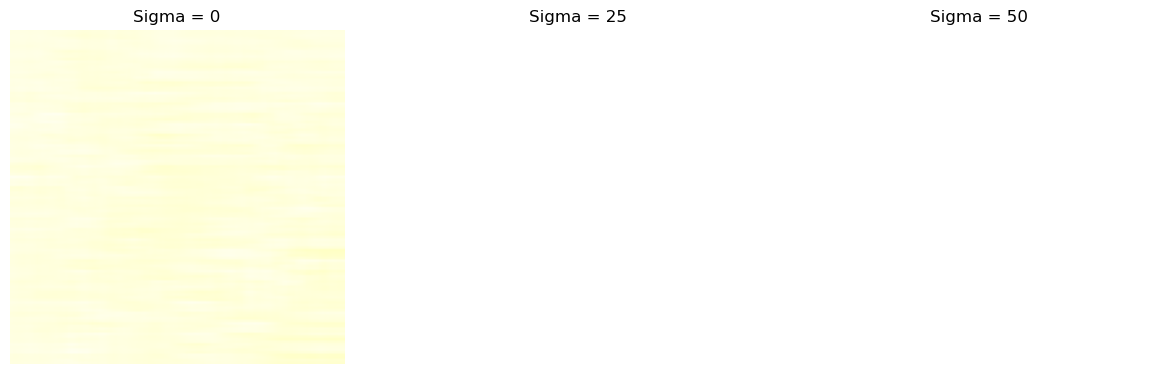

In [6]:
import torch
import torch.nn as nn
from libs.models import encoder4, decoder4
import numpy as np
from libs.Matrix import MulLayer
from libs.Loader import Dataset
import os
from typing import List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Set PYTORCH_CUDA_ALLOC_CONF to avoid fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

class StyleTransferNoiseApplication:
    def __init__(self, vgg: nn.Module, dec: nn.Module, matrix: MulLayer, style_layers: List[str], device: torch.device):
        self.device = torch.device('cpu')  # Force CPU to avoid CUDA OOM issues

        # Move all models to CPU and set to evaluation mode
        self.vgg = vgg.to(self.device).eval()
        self.dec = dec.to(self.device).eval()
        self.matrix = matrix.to(self.device)

        self.style_layers = style_layers

    def add_noise(self, matrix: torch.Tensor, sigma: float) -> torch.Tensor:
        """Adds random Gaussian noise to a matrix on CPU."""
        matrix = matrix.to('cpu')
        return matrix + torch.randn_like(matrix).cpu() * sigma

    @torch.no_grad()
    def generate_stylized_image(self, contentV: torch.Tensor, styleV: torch.Tensor, noisy_matrix: torch.Tensor) -> torch.Tensor:
        """Generates the stylized image using the given noisy transformation matrix on CPU."""
        # Force all operations to CPU
        contentV, styleV, noisy_matrix = contentV.to('cpu'), styleV.to('cpu'), noisy_matrix.to('cpu')

        sF, cF = self.vgg(styleV), self.vgg(contentV)

        transformed_features, _ = self.matrix(cF[self.style_layers[0]], sF[self.style_layers[0]])
        b, c, h, w = transformed_features.size()
        compressed_features = self.matrix.compress(transformed_features)

        noisy_transfeature = torch.bmm(noisy_matrix, compressed_features.view(b, self.matrix.matrixSize, -1))
        noisy_transfeature = noisy_transfeature.view(b, self.matrix.matrixSize, h, w)
        noisy_transfeature = self.matrix.unzip(noisy_transfeature)

        noisy_transfer = self.dec(noisy_transfeature).clamp(0, 1)
        return noisy_transfer


def process_and_save_comparative_plot(style_dir: str, opt, noise_application: StyleTransferNoiseApplication, sigmas: List[int]):
    style_path = os.path.join(opt.matrixPath, style_dir)
    matrix_files = [f for f in os.listdir(style_path) if f.endswith('.pth')]

    content_dataset = Dataset(opt.contentPath, opt.loadSize, opt.fineSize)
    style_dataset = Dataset(opt.stylePath, opt.loadSize, opt.fineSize)

    # Use only the first content and style image for this comparative analysis
    contentV, _ = content_dataset[0]
    styleV, _ = style_dataset[0]
    contentV = contentV.unsqueeze(0).to('cpu')
    styleV = styleV.unsqueeze(0).to('cpu')

    for matrix_file in tqdm(matrix_files, desc=f"Processing {style_dir}"):
        matrix_path = os.path.join(style_path, matrix_file)
        saved_matrix = torch.load(matrix_path, map_location='cpu', weights_only=True)  # Load matrix on CPU

        # Prepare a plot for sigma = 0, 25, 50, 75, 100
        plt.figure(figsize=(25, 5))
        num_images = len(sigmas)

        for idx, sigma in enumerate(sigmas):
            noisy_matrix = noise_application.add_noise(saved_matrix, sigma)
            stylized_image = noise_application.generate_stylized_image(contentV, styleV, noisy_matrix)

            # Plot each stylized image
            plt.subplot(1, num_images, idx + 1)
            image = stylized_image.squeeze().permute(1, 2, 0).numpy()
            plt.imshow(image)
            plt.title(f'Sigma = {sigma}')
            plt.axis('off')

        plt.suptitle(f'Stylized Images for Style: {style_dir} - Matrix: {matrix_file}')
        plt.tight_layout()
        output_file = f'comparative_stylized_images_{style_dir}_{matrix_file}.png'.replace('.pth', '')
        plt.savefig(output_file)
        plt.close()


def main():
    # Use CPU for all computations to avoid CUDA memory issues
    device = torch.device("cpu")

    # Load models
    vgg, dec, matrix = load_models(device)

    # Define options and parameters
    opt = Options()
    sigmas = [0, 25, 50, 75, 100]  # Noise levels to test

    # Initialize the noise application object
    noise_application = StyleTransferNoiseApplication(vgg, dec, matrix, style_layers=['r41'], device=device)

    # Loop over style directories
    style_dirs = os.listdir(opt.matrixPath)

    for style_dir in style_dirs:
        # Process each style directory and save comparative plots
        process_and_save_comparative_plot(style_dir, opt, noise_application, sigmas)


class Options:
    def __init__(self):
        self.contentPath = "data/content/"
        self.stylePath = "data/style/"
        self.loadSize = 128  # Reduced load size to minimize memory usage
        self.fineSize = 128  # Reduced fine size to minimize memory usage
        self.matrixPath = "Matrices/"


def load_models(device: torch.device) -> Tuple[nn.Module, nn.Module, MulLayer]:
    vgg = encoder4()
    dec = decoder4()
    matrix = MulLayer('r41')
    # Load models on CPU
    vgg.load_state_dict(torch.load('models/vgg_r41.pth', map_location='cpu'))
    dec.load_state_dict(torch.load('models/dec_r41.pth', map_location='cpu'))
    return vgg, dec, matrix


if __name__ == "__main__":
    main()


/tmp/ipykernel_73368/77636535.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg.load_state_dict(torch.load('models/vgg_r41.pth', map_location='cpu'))
/tmp/ipykernel_

Content image stats: min=0.0078, max=0.9490, mean=0.3698
Style image stats: min=0.0039, max=0.9765, mean=0.6294
Content feature stats: min=0.0000, max=38.9285, mean=2.5378
Style feature stats: min=0.0000, max=43.3326, mean=2.3322
Transformed feature stats: min=-975.9003, max=784.2540, mean=-1.3225
Stylized image stats: min=1.0000, max=1.0000, mean=1.0000


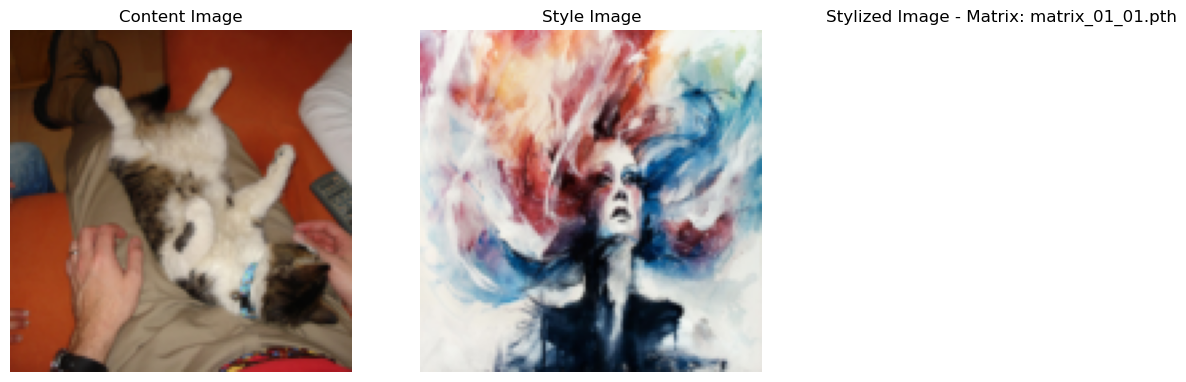

Processing style matrices:   6%|▋         | 1/16 [00:07<01:58,  7.91s/it]

Content image stats: min=0.0196, max=0.9529, mean=0.4754
Style image stats: min=0.0314, max=0.7529, mean=0.3577
Content feature stats: min=0.0000, max=46.1650, mean=2.1439
Style feature stats: min=0.0000, max=36.9134, mean=2.3094
Transformed feature stats: min=-1092.4475, max=799.4754, mean=-0.4727
Stylized image stats: min=1.0000, max=1.0000, mean=1.0000


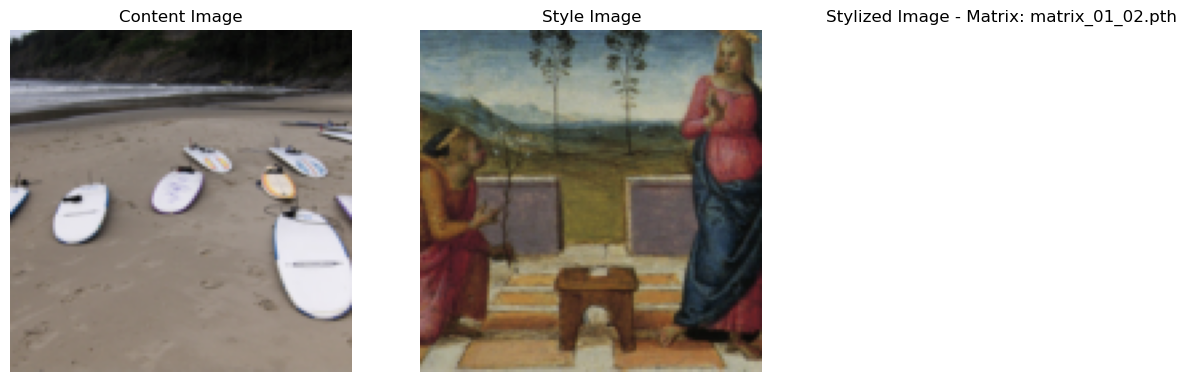

Processing style matrices:  12%|█▎        | 2/16 [00:17<02:07,  9.08s/it]

Content image stats: min=0.0196, max=1.0000, mean=0.5587
Style image stats: min=0.0588, max=0.9961, mean=0.7713
Content feature stats: min=0.0000, max=36.8535, mean=2.0759
Style feature stats: min=0.0000, max=33.7099, mean=1.9168
Transformed feature stats: min=-785.3157, max=833.6770, mean=-2.7496
Stylized image stats: min=1.0000, max=1.0000, mean=1.0000


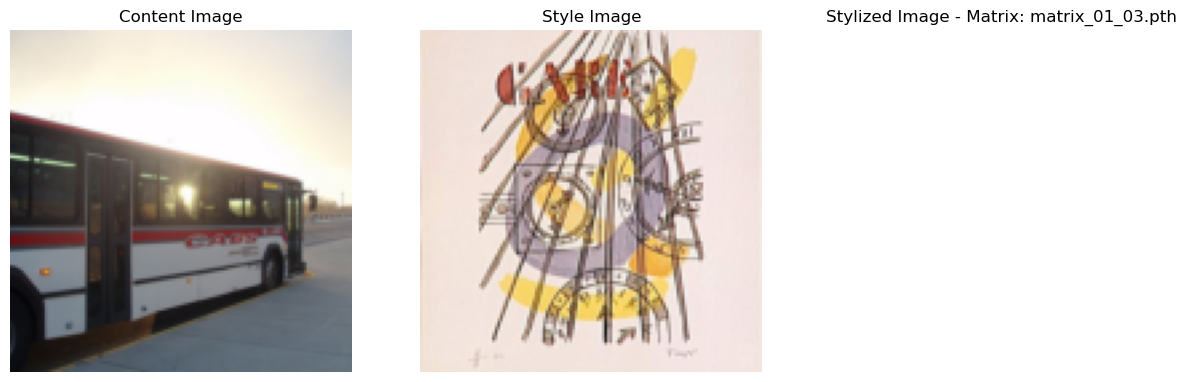

In [ ]:
import torch
import torch.nn as nn
from libs.models import encoder4, decoder4
from libs.Matrix import MulLayer
from libs.Loader import Dataset
import os
from typing import List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

class StyleTransferApplication:
    def __init__(self, vgg: nn.Module, dec: nn.Module, matrix: MulLayer, style_layers: List[str], device: torch.device):
        self.device = torch.device('cpu')
        self.vgg = vgg.to(self.device).eval()
        self.dec = dec.to(self.device).eval()
        self.matrix = matrix.to(self.device)
        self.style_layers = style_layers

    @torch.no_grad()
    def generate_stylized_image(self, contentV: torch.Tensor, styleV: torch.Tensor, matrix: torch.Tensor) -> torch.Tensor:
        contentV, styleV, matrix = contentV.to('cpu'), styleV.to('cpu'), matrix.to('cpu')
        
        # Normalize input images
        contentV = self.normalize(contentV)
        styleV = self.normalize(styleV)
        
        sF, cF = self.vgg(styleV), self.vgg(contentV)
        
        # Print feature statistics for debugging
        print(f"Content feature stats: min={cF[self.style_layers[0]].min():.4f}, max={cF[self.style_layers[0]].max():.4f}, mean={cF[self.style_layers[0]].mean():.4f}")
        print(f"Style feature stats: min={sF[self.style_layers[0]].min():.4f}, max={sF[self.style_layers[0]].max():.4f}, mean={sF[self.style_layers[0]].mean():.4f}")
        
        transformed_features, _ = self.matrix(cF[self.style_layers[0]], sF[self.style_layers[0]])
        b, c, h, w = transformed_features.size()
        compressed_features = self.matrix.compress(transformed_features)
        transformed_feature = torch.bmm(matrix, compressed_features.view(b, self.matrix.matrixSize, -1))
        transformed_feature = transformed_feature.view(b, self.matrix.matrixSize, h, w)
        transformed_feature = self.matrix.unzip(transformed_feature)
        
        # Print transformed feature statistics
        print(f"Transformed feature stats: min={transformed_feature.min():.4f}, max={transformed_feature.max():.4f}, mean={transformed_feature.mean():.4f}")
        
        stylized_image = self.dec(transformed_feature)
        
        # Denormalize output image
        stylized_image = self.denormalize(stylized_image)
        
        return stylized_image.clamp(0, 1)

    def normalize(self, img):
        return (img - 0.5) * 2

    def denormalize(self, img):
        return (img / 2) + 0.5

def process_and_plot_stylized_images(opt, style_transfer: StyleTransferApplication):
    style_path = os.path.join(opt.matrixPath, "01")
    matrix_files = sorted([f for f in os.listdir(style_path) if f.endswith('.pth')])

    content_dataset = Dataset(opt.contentPath, opt.loadSize, opt.fineSize)
    style_dataset = Dataset(opt.stylePath, opt.loadSize, opt.fineSize)

    for idx, matrix_file in enumerate(tqdm(matrix_files, desc="Processing style matrices")):
        matrix_path = os.path.join(style_path, matrix_file)
        saved_matrix = torch.load(matrix_path, map_location='cpu')

        contentV, _ = content_dataset[idx % len(content_dataset)]
        styleV, _ = style_dataset[idx % len(style_dataset)]
        contentV = contentV.unsqueeze(0).to('cpu')
        styleV = styleV.unsqueeze(0).to('cpu')

        # Print input image statistics
        print(f"Content image stats: min={contentV.min():.4f}, max={contentV.max():.4f}, mean={contentV.mean():.4f}")
        print(f"Style image stats: min={styleV.min():.4f}, max={styleV.max():.4f}, mean={styleV.mean():.4f}")

        stylized_image = style_transfer.generate_stylized_image(contentV, styleV, saved_matrix)

        # Print output image statistics
        print(f"Stylized image stats: min={stylized_image.min():.4f}, max={stylized_image.max():.4f}, mean={stylized_image.mean():.4f}")

        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(contentV.squeeze().permute(1, 2, 0).numpy())
        plt.title('Content Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(styleV.squeeze().permute(1, 2, 0).numpy())
        plt.title('Style Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(stylized_image.squeeze().permute(1, 2, 0).numpy())
        plt.title(f'Stylized Image - Matrix: {matrix_file}')
        plt.axis('off')
        
        plt.show()
        
        # Ask user if they want to continue
        user_input = input("Press Enter to continue to the next image, or type 'q' to quit: ")
        if user_input.lower() == 'q':
            break

def main():
    device = torch.device("cpu")
    vgg, dec, matrix = load_models(device)
    opt = Options()
    style_transfer = StyleTransferApplication(vgg, dec, matrix, style_layers=['r41'], device=device)
    process_and_plot_stylized_images(opt, style_transfer)

class Options:
    def __init__(self):
        self.contentPath = "data/content/"
        self.stylePath = "data/style/"
        self.loadSize = 128
        self.fineSize = 128
        self.matrixPath = "Matrices/"

def load_models(device: torch.device) -> Tuple[nn.Module, nn.Module, MulLayer]:
    vgg = encoder4()
    dec = decoder4()
    matrix = MulLayer('r41')
    vgg.load_state_dict(torch.load('models/vgg_r41.pth', map_location='cpu'))
    dec.load_state_dict(torch.load('models/dec_r41.pth', map_location='cpu'))
    return vgg, dec, matrix

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from libs.Loader import Dataset
from libs.models import encoder4, decoder4
from libs.Criterion import LossCriterion
from libs.Matrix import MulLayer
import os
from typing import List, Tuple
from tqdm import tqdm
import torch.nn.functional as F


class LossSensitivity:
    def __init__(self, vgg: nn.Module, dec: nn.Module, matrix: MulLayer,
                 style_layers: List[str], content_layers: List[str],
                 style_weight: float, content_weight: float, device: torch.device):
        self.vgg = vgg.to(device)
        self.dec = dec.to(device)
        self.matrix = matrix.to(device)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.criterion = LossCriterion(style_layers, content_layers, style_weight, content_weight)
        self.device = device

    def add_noise(self, matrix: torch.Tensor, sigma: float) -> torch.Tensor:
        """Adds random Gaussian noise to a matrix."""
        return matrix + torch.randn_like(matrix) * sigma

    @torch.no_grad()
    def forward(self, contentV: torch.Tensor, styleV: torch.Tensor) -> Tuple[dict, dict]:
        return self.vgg(styleV), self.vgg(contentV)

    def compute_loss(self, contentV: torch.Tensor, styleV: torch.Tensor, noisy_matrix: torch.Tensor) -> float:
        sF, cF = self.forward(contentV, styleV)

        transformed_features, _ = self.matrix(cF[self.style_layers[0]], sF[self.style_layers[0]])
        b, c, h, w = transformed_features.size()
        compressed_features = self.matrix.compress(transformed_features)

        if noisy_matrix.size(1) != compressed_features.view(b, self.matrix.matrixSize, -1).size(1):
            print(f"Dimension mismatch: {noisy_matrix.size()} vs {compressed_features.size()}")
            return float('inf')

        noisy_transfeature = torch.bmm(noisy_matrix, compressed_features.view(b, self.matrix.matrixSize, -1))
        noisy_transfeature = noisy_transfeature.view(b, self.matrix.matrixSize, h, w)
        noisy_transfeature = self.matrix.unzip(noisy_transfeature)

        noisy_transfer = self.dec(noisy_transfeature).clamp(0, 1)
        tF = self.vgg(noisy_transfer)

        total_loss, _, _ = self.criterion(tF, sF, cF)
        return total_loss.item()

    def run_experiment(self, contentV: torch.Tensor, styleV: torch.Tensor,
                       sigmas: np.ndarray, matrix: torch.Tensor) -> List[float]:
        loss_values = []

        for sigma in sigmas:
            noisy_matrix = self.add_noise(matrix, sigma)

            loss = self.compute_loss(contentV, styleV, noisy_matrix)
            if loss == float('inf'):
                print(f"Skipping sigma {sigma} due to dimension mismatch.")
                continue

            loss_values.append(loss)  # Store only the loss related to random noise

        return loss_values


def process_style_dir(style_dir: str, opt, loss_sensitivity: LossSensitivity,
                      sigmas: np.ndarray, device: torch.device) -> List[float]:
    style_path = os.path.join(opt.matrixPath, style_dir)
    matrix_files = [f for f in os.listdir(style_path) if f.endswith('.pth')]

    total_loss_values = np.zeros(len(sigmas))
    num_matrices = 0

    content_dataset = Dataset(opt.contentPath, opt.loadSize, opt.fineSize)
    style_dataset = Dataset(opt.stylePath, opt.loadSize, opt.fineSize)

    # Loop over all matrices saved for this style
    for matrix_file in tqdm(matrix_files, desc=f"Processing {style_dir}"):
        matrix_path = os.path.join(style_path, matrix_file)
        saved_matrix = torch.load(matrix_path, map_location=device)

        num_content_images = 0
        loss_values_accumulated = np.zeros(len(sigmas))

        # Loop over all content images
        for contentV, _ in content_dataset:
            contentV = contentV.unsqueeze(0).to(device)
            styleV = style_dataset[0][0].unsqueeze(0).to(device)

            # Run experiment for this content image
            loss_values = loss_sensitivity.run_experiment(contentV, styleV, sigmas, saved_matrix)

            # Accumulate losses for each sigma
            loss_values_accumulated += np.array(loss_values)
            num_content_images += 1

        # Average loss values for each content image and add to total losses
        total_loss_values += loss_values_accumulated / num_content_images
        num_matrices += 1

    # Average the accumulated results over the number of style matrices
    avg_loss_values = total_loss_values / num_matrices

    return avg_loss_values


def plot_style_results(style_dir: str, sigmas: np.ndarray, avg_loss_values: np.ndarray):
    plt.figure(figsize=(10, 6))

    plt.plot(sigmas, avg_loss_values, '-o')
    plt.xlabel('Sigma (Noise Level)')
    plt.ylabel('Average Loss')
    plt.title(f'Loss Sensitivity for Style: {style_dir}')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'noise_sensitivity_{style_dir}.png')
    plt.show()


def plot_average_loss_trend(sigmas: np.ndarray, all_styles_loss_values: List[np.ndarray]):
    """
    Plot the average loss trend across all styles with standard deviation.
    
    :param sigmas: Array of noise levels
    :param all_styles_loss_values: List of loss values for each style
    """
    avg_loss_values = np.mean(all_styles_loss_values, axis=0)
    std_loss_values = np.std(all_styles_loss_values, axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(sigmas, avg_loss_values, '-', color='blue', label='Average Loss')
    plt.fill_between(sigmas,
                     avg_loss_values - std_loss_values,
                     avg_loss_values + std_loss_values,
                     alpha=0.3, color='lightblue', label='±1 Standard Deviation')

    plt.xlabel('Sigma (Noise Level)')
    plt.ylabel('Average Loss')
    plt.title('Average Loss Trend Across All Styles')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('average_loss_trend.png', dpi=300)
    plt.show()

    print(f"Maximum average loss: {np.max(avg_loss_values):.4f}")
    print(f"Maximum standard deviation: {np.max(std_loss_values):.4f}")
    print(f"Sigma at maximum average loss: {sigmas[np.argmax(avg_loss_values)]:.4f}")


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load models
    vgg, dec, matrix = load_models(device)

    # Define options and parameters
    opt = Options()
    sigmas = np.linspace(0, 100, 10)  # Noise levels to test

    # Initialize the loss sensitivity object with valid layer identifiers
    loss_sensitivity = LossSensitivity(vgg, dec, matrix, style_layers=['r41'], content_layers=['r31'],
                                       style_weight=1.0, content_weight=1.0, device=device)

    # Loop over style directories
    style_dirs = os.listdir(opt.matrixPath)
    all_styles_loss_values = []

    for style_dir in style_dirs:
        # Process each style directory
        avg_loss_values = process_style_dir(style_dir, opt, loss_sensitivity, sigmas, device)

        # Plot results for the current style
        plot_style_results(style_dir, sigmas, avg_loss_values)

        # Store the results across all styles
        all_styles_loss_values.append(avg_loss_values)

    # Plot average loss trend across all styles
    plot_average_loss_trend(sigmas, all_styles_loss_values)


if __name__ == "__main__":
    main()


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from libs.Loader import Dataset
from libs.models import encoder4, decoder4
from libs.Criterion import LossCriterion
from libs.Matrix import MulLayer
import os
from typing import List, Tuple
from tqdm import tqdm
import torch.nn.functional as F


class LossSensitivity:
    def __init__(self, vgg: nn.Module, dec: nn.Module, matrix: MulLayer,
                 style_layers: List[str], content_layers: List[str],
                 style_weight: float, content_weight: float, device: torch.device):
        self.vgg = vgg.to(device)
        self.dec = dec.to(device)
        self.matrix = matrix.to(device)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.criterion = LossCriterion(style_layers, content_layers, style_weight, content_weight)
        self.device = device

    def add_noise(self, matrix: torch.Tensor, sigma: float) -> torch.Tensor:
        """Adds random Gaussian noise to a matrix."""
        return matrix + torch.randn_like(matrix) * sigma

    @torch.no_grad()
    def forward(self, contentV: torch.Tensor, styleV: torch.Tensor) -> Tuple[dict, dict]:
        return self.vgg(styleV), self.vgg(contentV)

    def compute_loss(self, contentV: torch.Tensor, styleV: torch.Tensor, noisy_matrix: torch.Tensor) -> float:
        sF, cF = self.forward(contentV, styleV)

        transformed_features, _ = self.matrix(cF[self.style_layers[0]], sF[self.style_layers[0]])
        b, c, h, w = transformed_features.size()
        compressed_features = self.matrix.compress(transformed_features)

        if noisy_matrix.size(1) != compressed_features.view(b, self.matrix.matrixSize, -1).size(1):
            print(f"Dimension mismatch: {noisy_matrix.size()} vs {compressed_features.size()}")
            return float('inf')

        noisy_transfeature = torch.bmm(noisy_matrix, compressed_features.view(b, self.matrix.matrixSize, -1))
        noisy_transfeature = noisy_transfeature.view(b, self.matrix.matrixSize, h, w)
        noisy_transfeature = self.matrix.unzip(noisy_transfeature)

        noisy_transfer = self.dec(noisy_transfeature).clamp(0, 1)
        tF = self.vgg(noisy_transfer)

        total_loss, _, _ = self.criterion(tF, sF, cF)
        return total_loss.item()

    def generate_stylized_image(self, contentV: torch.Tensor, styleV: torch.Tensor, noisy_matrix: torch.Tensor) -> torch.Tensor:
        """Generates the stylized image using the given noisy transformation matrix."""
        sF, cF = self.forward(contentV, styleV)

        transformed_features, _ = self.matrix(cF[self.style_layers[0]], sF[self.style_layers[0]])
        b, c, h, w = transformed_features.size()
        compressed_features = self.matrix.compress(transformed_features)

        noisy_transfeature = torch.bmm(noisy_matrix, compressed_features.view(b, self.matrix.matrixSize, -1))
        noisy_transfeature = noisy_transfeature.view(b, self.matrix.matrixSize, h, w)
        noisy_transfeature = self.matrix.unzip(noisy_transfeature)

        noisy_transfer = self.dec(noisy_transfeature).clamp(0, 1)
        return noisy_transfer

    def run_experiment(self, contentV: torch.Tensor, styleV: torch.Tensor,
                       sigmas: np.ndarray, matrix: torch.Tensor) -> List[float]:
        """Runs the experiment for different noise levels and computes loss for each."""
        loss_values = []

        for sigma in sigmas:
            noisy_matrix = self.add_noise(matrix, sigma)

            loss = self.compute_loss(contentV, styleV, noisy_matrix)
            if loss == float('inf'):
                print(f"Skipping sigma {sigma} due to dimension mismatch.")
                continue

            loss_values.append(loss)  # Store only the loss related to random noise

        return loss_values


def process_style_dir(style_dir: str, opt, loss_sensitivity: LossSensitivity,
                      sigmas: np.ndarray, device: torch.device) -> Tuple[List[float], List[Tuple[float, torch.Tensor]]]:
    style_path = os.path.join(opt.matrixPath, style_dir)
    matrix_files = [f for f in os.listdir(style_path) if f.endswith('.pth')]

    total_loss_values = np.zeros(len(sigmas))
    num_matrices = 0

    content_dataset = Dataset(opt.contentPath, opt.loadSize, opt.fineSize)
    style_dataset = Dataset(opt.stylePath, opt.loadSize, opt.fineSize)

    # For storing intermediate stylized images
    intermediate_images = []

    # Loop over all matrices saved for this style
    for matrix_file in tqdm(matrix_files, desc=f"Processing {style_dir}"):
        matrix_path = os.path.join(style_path, matrix_file)
        saved_matrix = torch.load(matrix_path, map_location=device)

        num_content_images = 0
        loss_values_accumulated = np.zeros(len(sigmas))

        # Loop over all content images
        for contentV, _ in content_dataset:
            contentV = contentV.unsqueeze(0).to(device)
            styleV = style_dataset[0][0].unsqueeze(0).to(device)

            # Run experiment for this content image
            loss_values = loss_sensitivity.run_experiment(contentV, styleV, sigmas, saved_matrix)

            # Accumulate losses for each sigma
            loss_values_accumulated += np.array(loss_values)
            num_content_images += 1

            # Save intermediate stylized images for some sigma values
            for sigma_idx in [2, 5, 8]:  # Example indices for intermediate sigma levels
                sigma = sigmas[sigma_idx]
                noisy_matrix = loss_sensitivity.add_noise(saved_matrix, sigma)
                stylized_image = loss_sensitivity.generate_stylized_image(contentV, styleV, noisy_matrix)
                intermediate_images.append((sigma, stylized_image.cpu()))

        # Average loss values for each content image and add to total losses
        total_loss_values += loss_values_accumulated / num_content_images
        num_matrices += 1

    # Average the accumulated results over the number of style matrices
    avg_loss_values = total_loss_values / num_matrices

    return avg_loss_values, intermediate_images


def plot_style_results(style_dir: str, sigmas: np.ndarray, avg_loss_values: np.ndarray):
    plt.figure(figsize=(10, 6))

    plt.plot(sigmas, avg_loss_values, '-o')
    plt.xlabel('Sigma (Noise Level)')
    plt.ylabel('Average Loss')
    plt.title(f'Loss Sensitivity for Style: {style_dir}')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'noise_sensitivity_{style_dir}.png')
    plt.show()


def plot_intermediate_images(intermediate_images: List[Tuple[float, torch.Tensor]], style_dir: str):
    """Plot intermediate stylized images for the given sigma levels."""
    plt.figure(figsize=(15, 5))
    num_images = len(intermediate_images)

    for idx, (sigma, image_tensor) in enumerate(intermediate_images):
        plt.subplot(1, num_images, idx + 1)
        image = image_tensor.squeeze().permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.title(f'Sigma = {sigma:.2f}')
        plt.axis('off')

    plt.suptitle(f'Stylized Images for Style: {style_dir}')
    plt.tight_layout()
    plt.savefig(f'stylized_images_{style_dir}.png')
    plt.show()


def plot_average_loss_trend(sigmas: np.ndarray, all_styles_loss_values: List[np.ndarray]):
    """
    Plot the average loss trend across all styles with standard deviation.
    
    :param sigmas: Array of noise levels
    :param all_styles_loss_values: List of loss values for each style
    """
    avg_loss_values = np.mean(all_styles_loss_values, axis=0)
    std_loss_values = np.std(all_styles_loss_values, axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(sigmas, avg_loss_values, '-', color='blue', label='Average Loss')
    plt.fill_between(sigmas,
                     avg_loss_values - std_loss_values,
                     avg_loss_values + std_loss_values,
                     alpha=0.3, color='lightblue', label='±1 Standard Deviation')

    plt.xlabel('Sigma (Noise Level)')
    plt.ylabel('Average Loss')
    plt.title('Average Loss Trend Across All Styles')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('average_loss_trend.png', dpi=300)
    plt.show()

    print(f"Maximum average loss: {np.max(avg_loss_values):.4f}")
    print(f"Maximum standard deviation: {np.max(std_loss_values):.4f}")
    print(f"Sigma at maximum average loss: {sigmas[np.argmax(avg_loss_values)]:.4f}")


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load models
    vgg, dec, matrix = load_models(device)

    # Define options and parameters
    opt = Options()
    sigmas = np.linspace(0, 1.0, 10)  # Noise levels to test

    # Initialize the loss sensitivity object with valid layer identifiers
    loss_sensitivity = LossSensitivity(vgg, dec, matrix, style_layers=['r41'], content_layers=['r31'],
                                       style_weight=1.0, content_weight=1.0, device=device)

    # Loop over style directories
    style_dirs = os.listdir(opt.matrixPath)
    all_styles_loss_values = []

    for style_dir in style_dirs:
        # Process each style directory
        avg_loss_values, intermediate_images = process_style_dir(style_dir, opt, loss_sensitivity, sigmas, device)

        # Plot results for the current style
        plot_style_results(style_dir, sigmas, avg_loss_values)

        # Plot intermediate stylized images for the current style
        plot_intermediate_images(intermediate_images, style_dir)

        # Store the results across all styles
        all_styles_loss_values.append(avg_loss_values)

    # Plot average loss trend across all styles
    plot_average_loss_trend(sigmas, all_styles_loss_values)


if __name__ == "__main__":
    main()
